In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pprint
import lorem
import random
import re
import os
import json

from transformers import BertTokenizer, GPT2Tokenizer

### Setup Words Vocabulary

In [13]:
def download_vocab(name="gpt2", path="./"):
    tok = GPT2Tokenizer.from_pretrained(name)
    tok.save_pretrained(path)
    
    os.remove(os.path.join(path, "tokenizer_config.json"))
    os.remove(os.path.join(path, "special_tokens_map.json"))
    print(f"{name} vocabulary downloaded to path: {path}")


path = "../datasets/clean/gpt2vocab"
download_vocab(path=path)

gpt2 vocabulary downloaded to path: ../datasets/clean/gpt2vocab


**Some changes should be done manualy from text editor...**

In [14]:
import  re
import os
import json

src_path = "../datasets/clean/gpt2vocab/vocab.json"
regex = {
    r'^(.)\1{2,}$': "m",        # match repetitive letters (3 or more)
    r'-?\d+': "s",              # search integers
    r'\\u[0-9a-fA-F]{4}': "s",   # search unicode caracters
    r'([@$,%^!&*)(._+\-=\[\]}{;":\\|,.<>?/~`]{2,})': "m", # random special caracters
}

print("Regex to remove:")
print(regex)
print("="*100)

with open(src_path, "r", encoding="utf-8") as f:
    vocab = json.load(f)
    print(f"initial vocab length: {len(vocab)}")
    print("="*100)
    to_delete = []
    print("to delete:")
    for r, t in regex.items():
        if t == "m":
            for word, id in vocab.items():
                if bool(re.fullmatch(r, word)):
                    # delete word from vocab
                    to_delete.append(word)
        else:
            for word, id in vocab.items():
                if bool(re.match(r, word)):
                    # delete word from vocab
                    to_delete.append(word)
        
    print(to_delete, "\n")
    for word in set(to_delete):
        del vocab[word]
        
    print("="*100) 
    print(f"final vocab length: {len(vocab)}")
    print("="*100)

dest_path = "../utils/tokenier/vocab/vocab.json"
with open(dest_path, "w") as f:
    json.dump(vocab, f, indent=4)
    
print("done!")

Regex to remove:
{'^(.)\\1{2,}$': 'm', '-?\\d+': 's', '\\\\u[0-9a-fA-F]{4}': 's', '([@$,%^!&*)(._+\\-=\\[\\]}{;":\\\\|,.<>?/~`]{2,})': 'm'}
initial vocab length: 50257
to delete:
['!!!', '!!!!', '!!!!!', '!!!!!!!!', '"""', '###', '####', '########', '################', '################################', '$$$$', '%%%%', "''''", ')))', '))))', '***', '****', '*****', '********', '************', '****************', '********************************', '+++', '++++', '++++++++', '++++++++++++++++', ',,,,', ',,,,,,,,', '---', '----', '-----', '------', '-------', '--------', '---------', '----------', '-----------', '------------', '-------------', '--------------', '---------------', '----------------', '--------------------', '------------------------', '--------------------------------', '------------------------------------------------', '--------------------------------------------------------', '----------------------------------------------------------------', '...', '....', '.....',

**NOTE:** the following two cells should be run one single time

In [26]:
with open(dest_path, "r") as f:
    print(f"initial length: {len(vocab)}")
    vocab = json.load(f)
    lower_vocab = {key.lower(): value for key, value in vocab.items()}
    new_vocab = {key: 1 for idx, key in enumerate(lower_vocab)}
    print(f"new length: {len(lower_vocab)}")

with open(dest_path, "w") as f:
    json.dump(new_vocab, f, indent=4)

initial length: 32226
new length: 32226


In [27]:
keywords_file_path = "../datasets/clean/keywords.txt"
vocab_file_path = "../utils/tokenier/vocab/vocab.json"

i = 1
with open(keywords_file_path, "r") as keywords_file, open(vocab_file_path, "r") as vocab_file:
    vocab = json.load(vocab_file)
    print(f"Initial vocab length: {len(vocab)}")
    for kw in keywords_file:
        vocab[kw.lower().replace("\n", "")] = i + 1
        i += 1

i -= 1
placeholders = ["<EMAIL>", "<SUB>", "<TIME>", "<DATE>", "<SERIES>", "<NUMBER>", "<REPETITIVE>", "<SINGLE>", "<REGEX>", "<SPECIAL>"]
for p in placeholders:
    vocab[p] = i + 1
    i += 1



with open(vocab_file_path, "w") as f:
    json.dump(vocab, f, indent=4)
    
print("done!")
print(f"New vocab length: {len(vocab)}")

Initial vocab length: 32226
done!
New vocab length: 32236


#### save the tokenizer into a file

In [28]:
special_characters = [
    "*", "(", ")", "[", "]", "{", "}", ".", ",", ":", ";", 
    "+", "-", "=", ">", "<", "?", "/", "\\", "|", "\"", "'",
    "~", "`", "^", "%", "&", "$", "#", "@", "!", "#", "==",
    "_", "**", "^", "!=", "<=", ">="
]

i -= 1
for s in special_characters:
    vocab[s] = i + 1
    i += 1

with open(vocab_file_path, "w") as f:
    json.dump(vocab, f, indent=4)

In [29]:
with open(vocab_file_path, "r") as f:
    v = json.load(f)
    print(max(v.values()))

554


In [22]:
vocab_file = "../utils/tokenier/vocab/vocab.json"
merges_file = "../utils/tokenier/vocab/merges.txt"
tokenizer = GPT2Tokenizer(vocab_file=vocab_file, 
                          merges_file=merges_file,
                          unk_token="<|unk|>",
                          bos_token="<|bos|>",
                          eos_token="<|eos|>"
                         )
placeholders = ["<EMAIL>", "<SUB>", "<TIME>", "<DATE>", "<SERIES>", "<NUMBER>", "<REPETITIVE>", "<SINGLE>", "<REGEX>", "<SPECIAL>"]
special_tokens_dict = {'additional_special_tokens': placeholders}
tokenizer.add_special_tokens(special_tokens_dict)

0

In [23]:
path = "../utils/tokenier/gpt2tokenizer/"
tokenizer.save_pretrained(path)

('../utils/tokenier/gpt2tokenizer/tokenizer_config.json',
 '../utils/tokenier/gpt2tokenizer/special_tokens_map.json',
 '../utils/tokenier/gpt2tokenizer/vocab.json',
 '../utils/tokenier/gpt2tokenizer/merges.txt',
 '../utils/tokenier/gpt2tokenizer/added_tokens.json')

## Get and setup data

In [24]:
with open("../datasets/clean/sqli.txt") as source1:
    sqli = list(source1)

In [25]:
sqli[:5]

['SELECT * FROM Customers;\n',
 "SELECT CustomerName, Email FROM Customers WHERE City = 'Paris';\n",
 'SELECT ProductID, ProductName, Price FROM Products ORDER BY Price ASC LIMIT 20;\n',
 'SELECT o.OrderID, c.CustomerName, p.ProductName FROM Orders o JOIN Customers c ON o.CustomerID = c.CustomerID JOIN Products p ON o.ProductID = p.ProductID;\n',
 "SELECT EmployeeID, FirstName, LastName, Department FROM Employees WHERE Department IN ('Engineering', 'IT');\n"]

In [26]:
len(sqli)

2182

In [27]:
def pre_process(text):
    
    text = text.replace("\n", "")
    text = text.lower()
    text = text.strip()
    # text = text.replace(" ", "")
    
    text = re.sub(r'\s{2,}', ' ', text)
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '<EMAIL>', text)
    text = re.sub(r'\b\w+(?:\.\w+)+\b', '<SUB>', text)
    text = re.sub(r'(\d+:)+\d+', '<TIME>', text)
    text = re.sub(r'\d{4}-\d{2}-\d{2}', '<DATE>', text)
    text = re.sub(r'\b(\w+)(?:,\1)+\b', '<SERIES>', text)
    text = re.sub(r'\b\d+(?:,\d+)+\b', '<SERIES>', text)
    text = re.sub(r'\bchar\(\d+(?:\+\d+)*\)', '<SERIES>', text)
    text = re.sub(r'<SERIES>(?:\+<SERIES>)+', '<SERIES>', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\b', '<NUMBER>', text)
    text = re.sub(r'(.)\1{2,}', '<REPETITIVE>', text)
    text = re.sub(r'(?<=[@$%^!~/[\]\\` ])(?!a)\w(?=[@$%^!~/[\]\\` ])', '<SINGLE>', text)
    
    special_characters = r'[@$%^!~/[\]\-\`]'
    text = re.sub(rf'{special_characters}{{2,}}', '<REGEX>', text)
    text = re.sub(special_characters, '<SPECIAL>', text)

    text = text.replace(",", "")

    return text

In [28]:
sqli = list(map(pre_process, sqli))

In [29]:
random.seed(123)
random.shuffle(sqli)

In [30]:
listhead_sqli = sqli[:5]
pprint.pprint(listhead_sqli)

["insert into payment_methods (user_id method) values (<NUMBER> 'credit "
 "card');",
 'drop table olddata;',
 'alter table departments add column location varchar(<NUMBER>);',
 'select * from products where category_id = <NUMBER> and stock > <NUMBER>;',
 "select * from customers where city = 'los angeles';"]


In [31]:
def encode(data: list[str]) -> list[list[int]]:
    sequences = []
    for query in data:

        # query = pre_process(query)
        # print(query)
        tok = tokenizer.tokenize(query)
        # print(tok)
        tok = list(map(lambda x: x.replace("Ġ", ""), tok))
        tok = [item for item in tok if item != ""]
        # print(tok)
        
        for i, t in enumerate(tok):
            if bool(re.fullmatch(r'[a-zA-Z]', t)) or bool(re.fullmatch(r'-?\d+', t)):
                tok[i] = "<oov>"
        # print(tok)
        
        seq = tokenizer.convert_tokens_to_ids(tok)
        seq = [item for item in seq if item != None]
        # print(seq)
        sequences.append(seq)
    
    print("Done!")
    return sequences

In [32]:
encode(["Machine learning can ams make predictions based on data."])

Done!


[[1, 1, 1, 1, 1, 1, 227, 476, 523]]

In [33]:
sequences = encode(sqli)

Done!


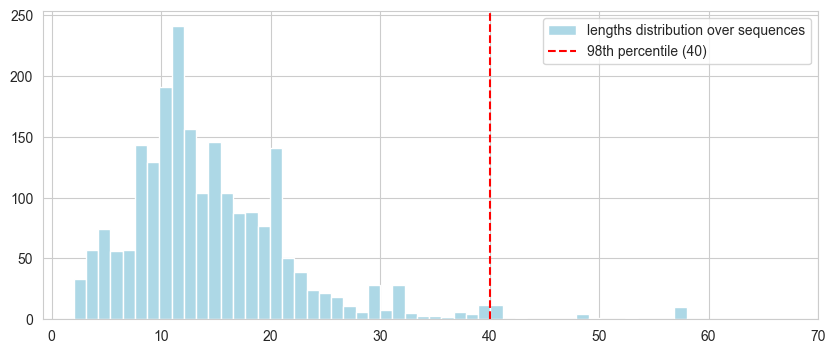

minimun length: 2
maximum length: 58
98th percentile: 40
above 98th percentile: 29 / 2182
below 98th percentile: 2143 / 2182
example of sequence with length 40: 
[[28615 19665 61772 45241 56896  3030 72122 85171 45081   788 36292 81261
  40962 38385 47371 40790 10930 87706 43294 39405 87613 52515 90828 93888
  64930 72662 83400  2047 17482 97654 41060 48355 10065 13927 39708 99819
  77877 68344 34595 96963]]


In [34]:
lengths = np.array([len(item) for item in sequences])
percentile_indice = 98
percentile = 40


sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(lengths, bins=50, color="lightblue", label="lengths distribution over sequences")
ax.axvline(x=percentile, linestyle="--", color="red", label=f"{percentile_indice}th percentile ({percentile})")
ax.set_xticks(np.arange(0, 75, 10))
ax.legend()
plt.show()

print(f"minimun length: {np.min(lengths)}")
print(f"maximum length: {np.max(lengths)}")
print(f"{percentile_indice}th percentile: {percentile}")
print(f"above {percentile_indice}th percentile: {sum(lengths>percentile)} / {len(lengths)}")
print(f"below {percentile_indice}th percentile: {sum(lengths<percentile)} / {len(lengths)}")

random_text = ""
while len(random_text) < percentile:
    random_text += lorem.sentence() + " "
print(f"example of sequence with length {percentile}: \n{np.random.randint(0, 99999, (1, percentile))}")

In [35]:
max_length = int(percentile)

In [36]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequences = pad_sequences(sequences=sequences, 
                          maxlen=max_length, 
                          padding="post", 
                          truncating="post")

In [37]:
sequences = np.array(sequences)
sequences.shape

(2182, 40)

In [38]:
data_path = "../datasets/clean/data-numpy.npy"
np.save(data_path, sequences)